<a href="https://colab.research.google.com/github/Le-Zheng/analytics-zoo/blob/image_segmentation/docs/docs/colab-notebook/orca/quickstart/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

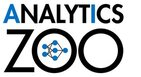
---

## **Environment Preparation**

**Install Java 8**

Run the command on the colaboratory file to install jdk 1.8:

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set jdk environment path which enables you to run Pyspark in your Colab environment.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)


**Install Analytics Zoo from pip**

You can also install the pre-release build version through `!pip install --pre  analytics-zoo`.

In [ ]:
# Install latest release version of analytics-zoo 
# Installing analytics-zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre analytics-zoo

In [ ]:
# Install python dependencies
!pip install tensorflow==1.15.0

## **Image Segmentation with Orca TF Estimator**
This is an example to demonstrate how to use Analytics-Zoo's Orca TF Estimator API to run distributed image segmentation training and inference task.

### **Init Orca Context**

This is the only place where you need to specify local or distributed mode. Specify loacl mode on Colab.

In [ ]:
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca import OrcaContext

# OrcaContext.log_output = True # recommended to set it to True when running Analytics Zoo in Jupyter notebook (this will display  terminal's  stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=4, memory="3g")

### **Define the Model**


* Build the U-Net model

We'll build the U-Net model. U-Net is especially good with segmentation tasks because it can localize well to provide high resolution segmentation masks. In addition, it works well with small datasets and is relatively robust against overfitting as the training data is in terms of the number of patches within an image, which is much larger than the number of training images itself. Unlike the original model, we will add batch normalization to each of our blocks. 

The Unet is built with an encoder portion and a decoder portion. The encoder portion is composed of a linear stack of [`Conv`](https://developers.google.com/machine-learning/glossary/#convolution), `BatchNorm`, and [`Relu`](https://developers.google.com/machine-learning/glossary/#ReLU) operations followed by a [`MaxPool`](https://developers.google.com/machine-learning/glossary/#pooling). Each `MaxPool` will reduce the spatial resolution of our feature map by a factor of 2. We keep track of the outputs of each block as we feed these high resolution feature maps with the decoder portion. The Decoder portion is comprised of UpSampling2D, Conv, BatchNorm, and Relus. Note that we concatenate the feature map of the same size on the decoder side. Finally, we add a final Conv operation that performs a convolution along the channels for each individual pixel (kernel size of (1, 1)) that outputs our final segmentation mask in grayscale. 
  
We'll build these helper functions that will allow us to ensemble our model block operations easily and simply. 


In [ ]:
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

 # Build the U-Net model  
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

inputs = layers.Input(shape=(128, 128, 3))      # 128
encoder0_pool, encoder0 = encoder_block(inputs, 16)     # 64
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 32)      # 32
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 64)      # 16
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 128)     # 8
center = conv_block(encoder3_pool, 256)     # center
decoder3 = decoder_block(center, encoder3, 128)     # 16
decoder2 = decoder_block(decoder3, encoder2, 64)    # 32
decoder1 = decoder_block(decoder2, encoder1, 32)    # 64
decoder0 = decoder_block(decoder1, encoder0, 16)    # 128
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

net = models.Model(inputs=[inputs], outputs=[outputs])

* Define custom metrics and loss functions

Defining loss and metric functions are simple with Keras. Simply define a function that takes both the True labels for a given example and the Predicted labels for the same given example.

Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the paper, where it was introduced.

We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly.

In [ ]:
 # Define custom metrics
def dice_coeff(y_true, y_pred):
  smooth = 1.
  # Flatten
  y_true_f = tf.reshape(y_true, [-1])
  y_pred_f = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / \
  (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  return score

# Define custom loss function
def dice_loss(y_true, y_pred):
  loss = 1 - dice_coeff(y_true, y_pred)
  return loss

def bce_dice_loss(y_true, y_pred):
  loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
  return loss

### **Define Train Dataset**

**Get Data**

You **should manually download** the dataset from kaggle [carvana-image-masking-challenge](https://www.kaggle.com/c/carvana-image-masking-challenge/data) and put it to the following path. We will need three files, `train.zip`, `train_mask.zip` and `train_mask.csv.zip`
You should manually download the dataset from kaggle carvana-image-masking-challenge, and save it to /tmp/carvana/. We will need three files, train.zip, train_masks.zip and train_masks.csv.zip

You can follow [easiest way to download kaggle data in Google Colab](https://www.kaggle.com/general/74235) to download and use kaggle data within Google Colab.

In [ ]:
# config kaggle within Colab
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (4).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# download the dataset from kaggle carvana-image-masking-challenge
!kaggle competitions download -c carvana-image-masking-challenge -p /tmp/carvana

In [ ]:
import argparse
import os
import zipfile
import pandas as pd
from PIL import Image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# Download data from Kaggle and unzip the files of interest. 
def load_data_from_zip(file_path, file):
    with zipfile.ZipFile(os.path.join(file_path, file), "r") as zip_ref:
        unzipped_file = zip_ref.namelist()[0]
        zip_ref.extractall(file_path)


def load_data(file_path):
    load_data_from_zip(file_path, 'train.zip')
    load_data_from_zip(file_path, 'train_masks.zip')
    load_data_from_zip(file_path, 'train_masks.csv.zip')

In [ ]:
file_path = "/tmp/carvana/"
load_data(file_path)

In [ ]:
img_dir = os.path.join(file_path, "train")
label_dir = os.path.join(file_path, "train_masks")

Here we only takes the first 1000 files for simplicity. You can use all images if you have enough computation resources.

In [ ]:
df_train = pd.read_csv(os.path.join(file_path, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])
ids_train = ids_train[:1000]

In [ ]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [ ]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
        train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

**Processing each pathname**

Since we begin with filenames, we will need to build a robust and scalable data pipeline that will play nicely with our model. 

In [ ]:
def load_and_process_image(path):
  array = mpimg.imread(path)
  result = np.array(Image.fromarray(array).resize(size=(128, 128)))
  result = result.astype(float)
  result /= 255.0
  return result

def load_and_process_image_label(path):
  array = mpimg.imread(path)
  result = np.array(Image.fromarray(array).resize(size=(128, 128)))
  result = np.expand_dims(result[:, :, 1], axis=-1)
  result = result.astype(float)
  result /= 255.0
  return result

In [ ]:
train_images = np.stack([load_and_process_image(filepath) for filepath in x_train_filenames])
train_label_images = np.stack([load_and_process_image_label(filepath)
                                   for filepath in y_train_filenames])

In [ ]:
val_images = np.stack([load_and_process_image(filepath) for filepath in x_val_filenames])
val_label_images = np.stack([load_and_process_image_label(filepath)
                                 for filepath in y_val_filenames])

In [ ]:
from zoo.orca.data import XShards

train_shards = XShards.partition({"x": train_images, "y": train_label_images})
val_shards = XShards.partition({"x": val_images, "y": val_label_images})

 ### **Fit with Orca Estimator**


Compile model


In [ ]:
from zoo.orca.learn.tf.estimator import Estimator

# compile model
net.compile(optimizer=tf.keras.optimizers.Adam(2e-3), loss=bce_dice_loss)
print(net.summary())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        activation[0][0]                 



Create an estimator from keras model



In [ ]:
est = Estimator.from_keras(keras_model=net)


Fit with estimator




In [ ]:
batch_size = 8
max_epoch = 8
est.fit(data=train_shards,
        batch_size=batch_size,
        epochs=max_epoch)



Evaluate with estimator



In [ ]:
result = est.evaluate(val_shards)
print(result)



Predict with estimator



In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

val_shards.cache()
val_image_shards = val_shards.transform_shard(lambda val_dict: {"x": val_dict["x"]})
pred_shards = est.predict(data=val_image_shards, batch_size=batch_size)
pred = pred_shards.collect()[0]["prediction"]
val_image_label = val_shards.collect()[0]
val_image = val_image_label["x"]
val_label = val_image_label["y"]

Visualize actual performance
We'll visualize our performance on the validation set.

Note that in an actual setting (competition, deployment, etc.) we'd evaluate on the test set with the full image resolution.

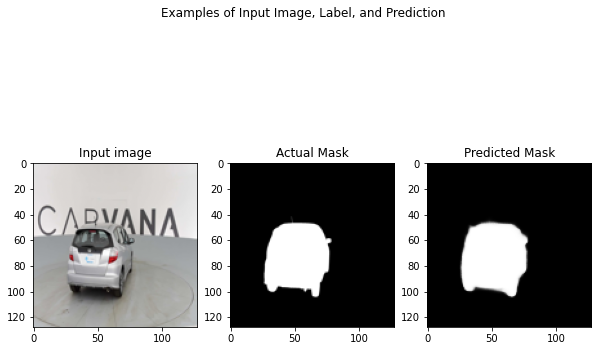

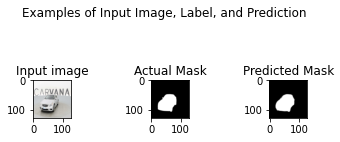

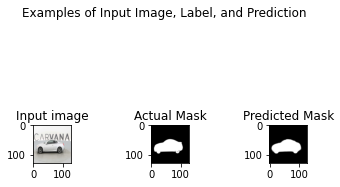

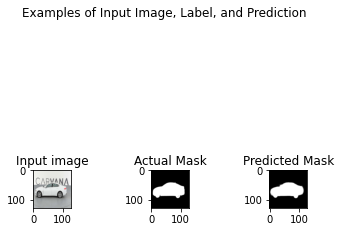

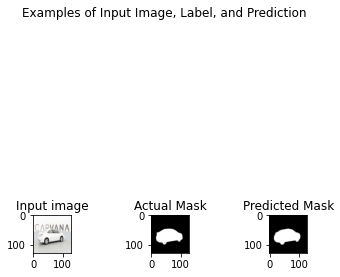

In [ ]:
platform = "linux"
non_interactive = False
if not non_interactive and platform == "mac":
  matplotlib.use('qt5agg')

if not non_interactive:
  # visualize 5 predicted results
  plt.figure(figsize=(10, 20))
  for i in range(5):
    img = val_image[i]
    label = val_label[i]
    predicted_label = pred[i]

    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(img)
    plt.title("Input image")

    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(label[:, :, 0], cmap='gray')
    plt.title("Actual Mask")
    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(predicted_label, cmap='gray')
    plt.title("Predicted Mask")
    plt.suptitle("Examples of Input Image, Label, and Prediction")

    plt.show()

Stop orca context

In [ ]:
stop_orca_context()